#Dependencies

In [7]:
# pip install lime


In [ ]:
!pip install -q optuna


In [2]:
 !pip install -q -U bnlp_toolkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 56.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 43.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.3 MB/s eta 0:00:00:00:01
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=daf1c6e18580acc207a46f747268abe1fb096a32b368bffafa50be5b36a49b08
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji
  Attempting unin

In [9]:
# !gdown 1y6R4r2azEusl4bLyussZcZvo3-wI3dCn

In [10]:
# !pip install fasttext

In [3]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
from bnlp import BasicTokenizer
from bnlp import SentencepieceTokenizer
from bnlp import BengaliWord2Vec
from bnlp import NLTKTokenizer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import precision_recall_fscore_support


In [4]:
df = pd.read_csv("/kaggle/input/hatespeech/train.csv")


#Cleaning

In [5]:
def clean_text(text):
    # Emoji removal pattern covering various emoji ranges
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    # Remove emojis
    text = emoji_pattern.sub(r'', text)
    # Remove English characters & numbers
    text = re.sub(r'[A-Za-z0-9]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove punctuation
    text = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]০১২৩৪৫৬৭৮৯', '', text)
    punctuations = '''`|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰🤣⚽️✌�￰৷￰'''
    # Create a character class to remove specified characters
    regex_pattern = '[' + re.escape(punctuations) + ']'
    text = re.sub(regex_pattern, '', text)


    return text



In [6]:
df['sentence'] = df['sentence'].apply(clean_text)


In [7]:
df = df.drop(columns=['target','type'])

#Describe Dataset

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40224 entries, 0 to 40223
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sentence     40224 non-null  object
 1   hate speech  40224 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 628.6+ KB


In [8]:
df.head()

,sentence,hate speech
0,ঐ ইন্দুর তোই মরছ নাই,1
1,গেবনের শেষে আইসা আপনার মুখোশ টা খুলছে এতেই আমি...,1
2,মুরগি চোরের পাছায় ডুকবি আর মারবি,1
3,কোটির চোদা খাওয়া শেষে এখন কোটির চোদা খাবে মিথিলা,1
4,য় মীর জাফরের মুখে মুতে দে,1


In [18]:
df.isnull().sum()

sentence       0
hate speech    0
dtype: int64

<Axes: xlabel='hate speech', ylabel='count'>

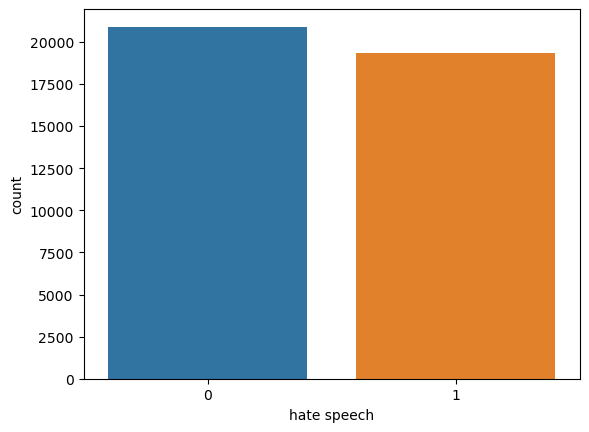

In [19]:
sns.countplot(data=df, x='hate speech')

In [20]:
print(df['sentence'].iloc[2],"\n")
print(df['sentence'].iloc[4],"\n")

মুরগি চোরের পাছায় ডুকবি আর মারবি 

য় মীর জাফরের মুখে মুতে দে 



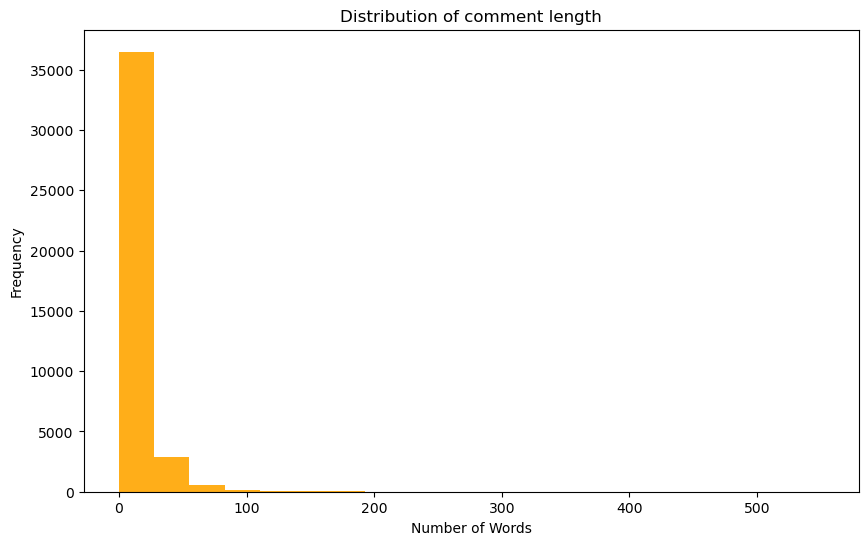

In [21]:
word_counts = df['sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, color='orange', alpha=0.9)
plt.title('Distribution of comment length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#Tokenization

Tokenize

In [9]:
basic_tokenizer = BasicTokenizer()

df['sentence'] = df['sentence'].apply(basic_tokenizer.tokenize)

In [10]:
df

,sentence,hate speech
0,"[ঐ, ইন্দুর, তোই, মরছ, নাই]",1
1,"[গেবনের, শেষে, আইসা, আপনার, মুখোশ, টা, খুলছে, ...",1
2,"[মুরগি, চোরের, পাছায়, ডুকবি, আর, মারবি]",1
3,"[কোটির, চোদা, খাওয়া, শেষে, এখন, কোটির, চোদা, খ...",1
4,"[য়, মীর, জাফরের, মুখে, মুতে, দে]",1
...,...,...
40219,"[গানটা, চালু, করে, ওয়াস, রুমে, গিয়েছিলাম, এসে,...",0
40220,"[হালকার, উপজেলা, ঝাপসা]",0
40221,[],0
40222,"[পুরাই, আগুনের, গুলা]",0


In [15]:
import ast

def clean_df(df, col):
    def is_empty_list(x):
        try:
            return isinstance(ast.literal_eval(x), list) and not ast.literal_eval(x)
        except (ValueError, SyntaxError, TypeError):
            return False

    return df[~df[col].apply(lambda x: is_empty_list(x) if isinstance(x, str) else False)].copy()

In [21]:
df = df[df['sentence'].astype(str).str.contains(r'\[\]', na=False) == False].reset_index()


In [22]:
df

,index,sentence,hate speech
0,0,"[ঐ, ইন্দুর, তোই, মরছ, নাই]",1
1,1,"[গেবনের, শেষে, আইসা, আপনার, মুখোশ, টা, খুলছে, ...",1
2,2,"[মুরগি, চোরের, পাছায়, ডুকবি, আর, মারবি]",1
3,3,"[কোটির, চোদা, খাওয়া, শেষে, এখন, কোটির, চোদা, খ...",1
4,4,"[য়, মীর, জাফরের, মুখে, মুতে, দে]",1
...,...,...,...
40215,40218,"[সাকিব, ভাইয়া, যেদিন, খেলবে, সেদিন, আমি, ক্রিক...",0
40216,40219,"[গানটা, চালু, করে, ওয়াস, রুমে, গিয়েছিলাম, এসে,...",0
40217,40220,"[হালকার, উপজেলা, ঝাপসা]",0
40218,40222,"[পুরাই, আগুনের, গুলা]",0


In [24]:
pf = df.copy()
pf

,sentence,hate speech
0,"[ঐ, ইন্দুর, তোই, মরছ, নাই]",1
1,"[গেবনের, শেষে, আইসা, আপনার, মুখোশ, টা, খুলছে, ...",1
2,"[মুরগি, চোরের, পাছায়, ডুকবি, আর, মারবি]",1
3,"[কোটির, চোদা, খাওয়া, শেষে, এখন, কোটির, চোদা, খ...",1
4,"[য়, মীর, জাফরের, মুখে, মুতে, দে]",1
...,...,...
40219,"[গানটা, চালু, করে, ওয়াস, রুমে, গিয়েছিলাম, এসে,...",0
40220,"[হালকার, উপজেলা, ঝাপসা]",0
40221,[],0
40222,"[পুরাই, আগুনের, গুলা]",0


Tf-idf

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

df['sentence'] = df['sentence'].apply(lambda x: ' '.join(x))  # Join tokens into a single string

# Apply TfidfVectorizer with unigram and bigram
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2), use_idf=True, tokenizer=lambda x: x.split())

# Apply TF-IDF to the joined (space-separated) text data
x_tfidf_bigram = tfidf_bigram.fit_transform(df['sentence'])

# If you have labels in 'hate speech' column
X_train, X_test, y_train, y_test = train_test_split(x_tfidf_bigram, df['hate speech'], test_size=0.2, random_state=42)


RandomForestClassifier(random_state=42)

Evaluator

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
def evaluate_model(model, X_test, y_test):
    # Model type display
    print(70*'-')
    print(f"Evaluating model: {model.__class__.__name__}")
    
    # Predict the results
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve (class 1 probabilities)

    # Compute accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    print(70*'-')


Train & evaluate

random forest

----------------------------------------------------------------------
Evaluating model: RandomForestClassifier
Accuracy: 0.8349
Precision: 0.8810
Recall: 0.7595
F1 Score: 0.8158


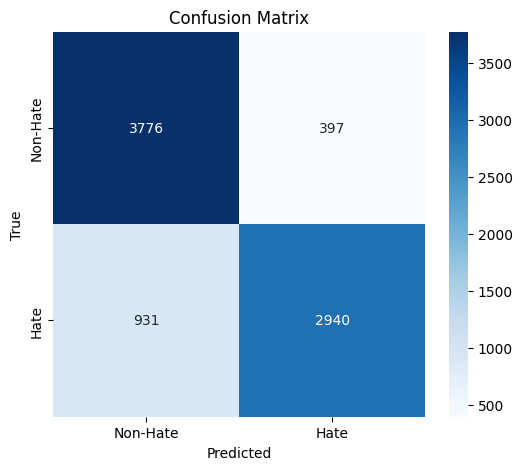

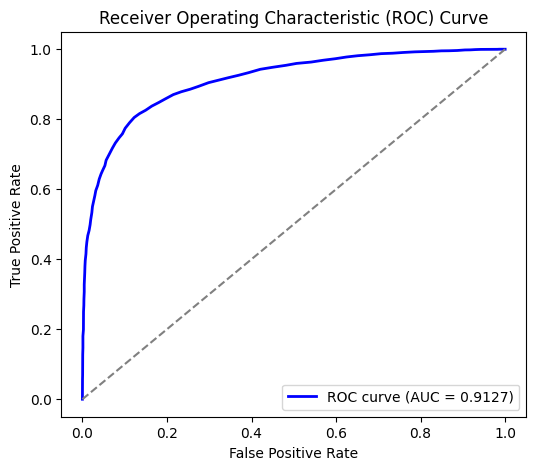

----------------------------------------------------------------------


In [41]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
evaluate_model(model_rf, X_test, y_test)

logistic regression

----------------------------------------------------------------------
Evaluating model: LogisticRegression
Accuracy: 0.8441
Precision: 0.8710
Recall: 0.7936
F1 Score: 0.8305


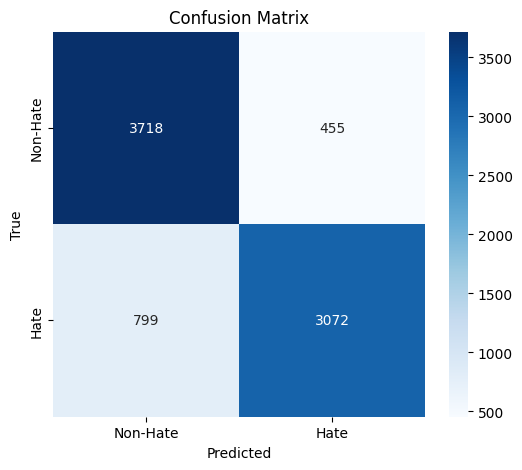

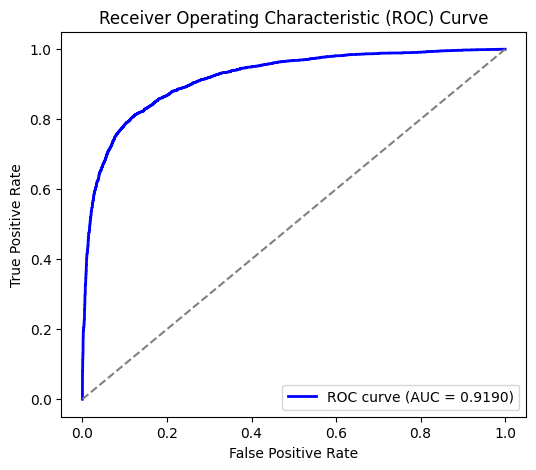

----------------------------------------------------------------------


In [43]:
model_lr = LogisticRegression(penalty='l2',random_state=0)
model_lr.fit(X_train, y_train)
evaluate_model(model_lr, X_test, y_test)

knn

----------------------------------------------------------------------
Evaluating model: KNeighborsClassifier
Accuracy: 0.7599
Precision: 0.7292
Recall: 0.7972
F1 Score: 0.7617


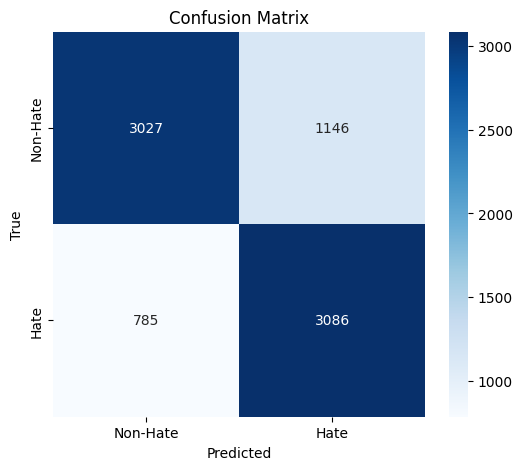

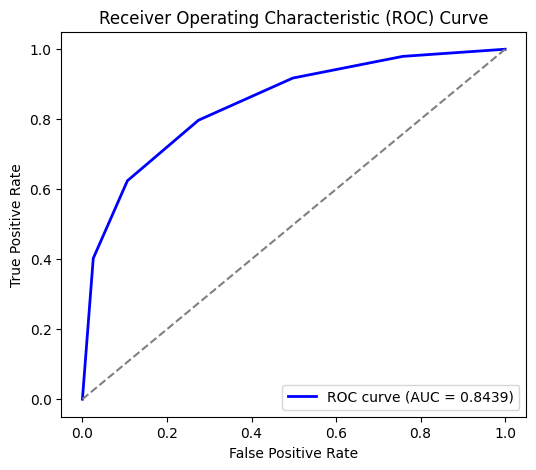

----------------------------------------------------------------------


In [45]:
model_knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model_knn.fit(X_train, y_train)
evaluate_model(model_knn, X_test, y_test)

svm

In [ ]:
model_sv = SVC(kernel='linear', random_state=42, probability=True)
model_sv.fit(X_train, y_train)
evaluate_model(model_sv, X_test, y_test)